In [1]:
import os
import pickle

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import skimage
import torch
import tifffile
from einops import rearrange
from torchio.transforms import Resize

import napari

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [10]:
mushroom_dir = '/Users/erikstorrs/Downloads/mushroom_50res/'

In [11]:
# mask_fp = '/Users/erikstorrs/Downloads/tissue_mask.tif'

In [12]:
background = [
#     0
]

masking_volume = pickle.load(open(
    os.path.join(mushroom_dir, f'nbhd_volumes_l2.pkl'), 'rb'
))['labeled']['multiplex']


mask = np.ones_like(masking_volume, dtype=bool)
for label in background:
    mask[masking_volume==label] = 0
mask.shape

(25, 132, 124)

In [13]:
np.unique(masking_volume)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [25]:
dtype = 'xenium'
level = 1

In [26]:
volume_outputs = pickle.load(open(
    os.path.join(mushroom_dir, f'nbhd_volumes_l{level}.pkl'), 'rb'
))
volume_outputs.keys()

dict_keys(['probs', 'labeled'])

In [27]:
outputs = pickle.load(open(
    os.path.join(mushroom_dir, 'outputs.pkl'), 'rb'
))
outputs.keys(), outputs['dtype_to_volume'].keys()

(dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg']),
 dict_keys(['he', 'multiplex', 'xenium', 'integrated']))

In [28]:
# volume = pickle.load(open('/Users/erikstorrs/Downloads/integrated.pkl', 'rb'))
# volume.shape

In [29]:
volume = volume_outputs['labeled'][dtype]
volume.shape

(25, 132, 124)

In [30]:
volume[~mask] = -1

In [31]:
# background = [
#     10, 11, 12, 15, 21
# ]

In [32]:
# l2_volume = pickle.load(open(
#     os.path.join(mushroom_dir, f'nbhd_volumes_l2.pkl'), 'rb'
# ))['labeled'][dtype]
# volume_outputs.keys()

# volume = volume_outputs['labeled'][dtype]
# volume.shape

# mask = np.ones_like(volume, dtype=bool)
# for label in background:
#     mask[volume==label] = 0
# mask.shape

In [33]:


# mask = tifffile.imread(mask_fp)
# mask = utils.rescale(mask, size=(volume.shape[-2], volume.shape[-1]), dim_order='h w', target_dtype=bool)
# volume[..., ~mask] = -1


clusters = np.unique(volume)
volume.shape, clusters

((25, 132, 124),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]))

In [34]:
z_scaler = 1. # do an additional downsample on z
target = (volume.shape[2], volume.shape[1], int(volume.shape[0] * z_scaler))
# target = (int(volume.shape[2] / z_scaler), int(volume.shape[1] / z_scaler), volume.shape[0])
transform = Resize(target, label_interpolation='nearest')
volume = transform(rearrange(volume, 'n h w -> 1 w h n'))
volume = rearrange(volume, '1 w h n -> n h w')
volume.shape

(25, 132, 124)

In [35]:
volume = np.vstack((
    np.expand_dims(np.zeros_like(volume[0]), 0) - 1,
    volume,
    np.expand_dims(np.zeros_like(volume[0]), 0) - 1,
))

In [36]:
# cmap = {i:x for i, x in enumerate(sns.color_palette('tab20'))}

In [37]:
cmap = vis_utils.get_hierarchical_cmap(outputs['dtype_to_cluster_to_agg'][dtype][level])

In [38]:
viewer = napari.Viewer(ndisplay=3, )
for cluster in clusters:
    viewer.add_labels(
        (volume==cluster).astype(int), name=cluster, visible=True, opacity=1., color={1:cmap.get(cluster, (1.,1.,1.))}, num_colors=1, )

state = viewer.window.qt_viewer.view.camera.get_state()
q = state['_quaternion']
q.w = -0.1342043174741573
q.x = -0.9830775909136398
q.y = 0.020420481999648066
q.z = 0.12300672879819263
viewer.window.qt_viewer.view.camera.set_state(state)

/var/folders/l4/tr_3w7sx31z58xhsnb0_07hw0000gr/T/ipykernel_16424/1908268452.py:6: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  state = viewer.window.qt_viewer.view.camera.get_state()
/var/folders/l4/tr_3w7sx31z58xhsnb0_07hw0000gr/T/ipykernel_16424/1908268452.py:12: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  viewer.window.qt_viewer.view.camera.set_state(state)


In [20]:
# state = viewer.window.qt_viewer.view.camera.get_state()
# state

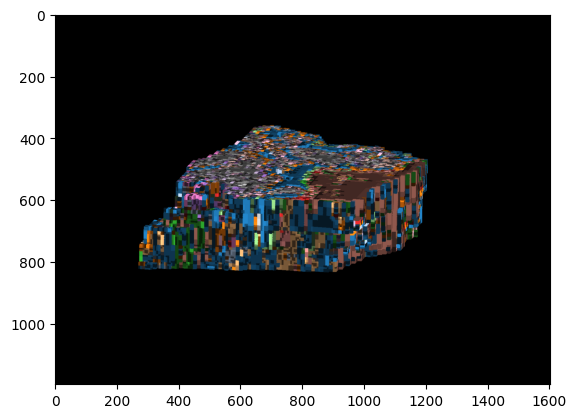

In [47]:
screenshot = viewer.screenshot()
mask = screenshot[..., :-1].sum(axis=-1) == 0
plt.imshow(screenshot)

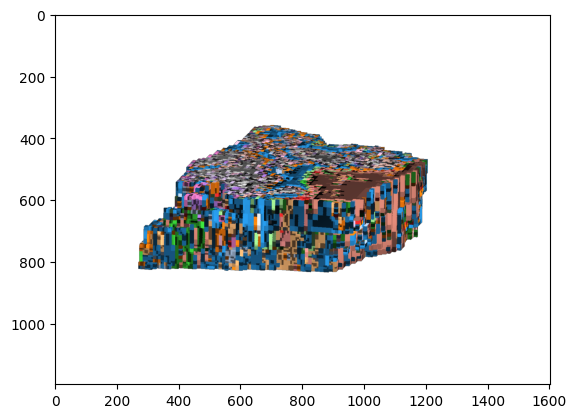

In [48]:
# need to adjust saturation to match viewer
screenshot = skimage.exposure.equalize_adapthist(screenshot, kernel_size=None, clip_limit=0.15, nbins=256)

screenshot *= 255
screenshot = screenshot.astype(np.uint8)

screenshot = np.concatenate(
    (screenshot, np.full((screenshot.shape[0], screenshot.shape[1], 1), 255, dtype=np.uint8)), axis=-1)
screenshot[mask, -1] = 0.
plt.imshow(screenshot)

In [23]:
skimage.io.imsave(f'/Users/erikstorrs/Downloads/HT413C1_nbhd_volume_{dtype}_l{level}.png', screenshot)

In [49]:
# skimage.io.imsave(f'/Users/erikstorrs/Downloads/HT413C1_nbhd_volume_integrated_l{level}.png', screenshot)